# Breaking ConvNets, a tensorflow example

The idea is: because the convolutional networks make linear transformations to the input to produce the output, the difference between different outputs (i.e. categories) are also linear, albeit high dimensional. Therefore, one can use tiny linear transformations made to the input (in this case usually a image) to choose which category does the image fall into.

### Start with generating adversarial images in a simple linear classifier

Following http://karpathy.github.io/2015/03/30/breaking-convnets/

Written in tensorflow using the MNIST dataset.

In [1]:
from __future__ import absolute_import
from __future__ import print_function
from __future__ import unicode_literals
from __future__ import division
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

seed = 42
np.random.seed(seed)
tf.set_random_seed(seed)
%matplotlib inline

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


Define a linear layer

In [2]:
def linear(input, output_dim, scope=None):
    norm = tf.random_normal_initializer()
    const = tf.constant_initializer(0.0)
    with tf.variable_scope(scope or 'linear'):
        w = tf.get_variable('w', [input.get_shape()[1], output_dim], initializer=norm)
        b = tf.get_variable('b', [output_dim], initializer=const)
        return tf.matmul(input, w) + b

Create a linear classifier with 784 inputs connecting directly to 10 softmax outputs

In [3]:
class Linear(object):
    def __init__(self, num_steps, batch_size, log_every):
        self.num_steps = num_steps
        self.batch_size = batch_size
        self.log_every = log_every
        self.hidden_size = 100
        with tf.variable_scope('Linear'):
            self._create_model()
        
    def _create_model(self):
        with tf.variable_scope('InOut'):
            self.x = tf.placeholder(tf.float32, shape=(None, 784))
            self.t = tf.placeholder(tf.float32, shape=(None, 10))
        with tf.variable_scope('Hidden'):
            self.y = linear(self.x, 10)
        with tf.variable_scope('Opt'):
            self.cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=self.y, labels=self.t))
            self.optimizer = tf.train.AdamOptimizer(1e-4).minimize(self.cross_entropy)
            correct_prediction = tf.equal(tf.argmax(self.y,1), tf.argmax(self.t,1))
            self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    def fool_model(self,imgs,target):
        with tf.variable_scope('Image'):
            img = tf.constant(imgs)
            t = np.zeros([10,10],dtype='float32')
            t[:,target] = 1
            t = tf.constant(t)
           
            self.two = tf.get_variable('imgs', initializer=img)
            self.six = tf.get_variable('targets', initializer=t)
        with tf.variable_scope('Hidden',reuse=True):
            self.y = linear(self.two, 10)
        with tf.variable_scope('Opt'):
            self.vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,scope='Linear/Image')

            self.cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=self.y, labels=self.six))
            self.optimizer = tf.train.AdamOptimizer(1e-3).minimize(self.cross_entropy, var_list=self.vars)
            correct_prediction = tf.equal(tf.argmax(self.y,1), tf.argmax(self.six,1))
            self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    def train(self):
        with tf.Session() as session:
            tf.global_variables_initializer().run()
            
            for i in range(self.num_steps):
                batch = mnist.train.next_batch(self.batch_size)
                if i%100 == 0:
                    train_accuracy = session.run(self.accuracy, feed_dict={self.x:batch[0], self.t: batch[1]})
                    print("step %d, training accuracy %g"%(i, train_accuracy))
                session.run([self.cross_entropy,self.optimizer], feed_dict={self.x: batch[0], self.t: batch[1]})
            saver = tf.train.Saver()
            save_path = saver.save(session, "./data/Linear.weights")
            print("Model saved in file: %s" % save_path)
            print("test accuracy %g"%session.run(self.accuracy, feed_dict={self.x:mnist.test.images, self.t: mnist.test.labels}))
            
    def fool(self,images,target=6):
        with tf.Session() as session:
            saver = tf.train.Saver()
            save_path = saver.restore(session, "./data/Linear.weights")
            with tf.variable_scope('Linear'):
                self.fool_model(twos,target)
            
            tf.global_variables_initializer().run()
            
            for i in range(300):
                CE,ACC,Y,_ = session.run([self.cross_entropy,self.accuracy,self.y,self.optimizer])
                print("step %d, cross entropy %g, training accuracy %g"%(i, CE, ACC))
                if i%10 == 0:
                    print(Y[0])
                if ACC==1.0:
                    print(Y[0])
                    break
                
            return session.run(self.two)

In [4]:
model = Linear(20000,100,100)
model.train()

step 0, training accuracy 0.07
step 100, training accuracy 0.11
step 200, training accuracy 0.07
step 300, training accuracy 0.06
step 400, training accuracy 0.08
step 500, training accuracy 0.08
step 600, training accuracy 0.09
step 700, training accuracy 0.09
step 800, training accuracy 0.12
step 900, training accuracy 0.06
step 1000, training accuracy 0.14
step 1100, training accuracy 0.1
step 1200, training accuracy 0.14
step 1300, training accuracy 0.1
step 1400, training accuracy 0.12
step 1500, training accuracy 0.14
step 1600, training accuracy 0.2
step 1700, training accuracy 0.16
step 1800, training accuracy 0.24
step 1900, training accuracy 0.2
step 2000, training accuracy 0.24
step 2100, training accuracy 0.22
step 2200, training accuracy 0.26
step 2300, training accuracy 0.27
step 2400, training accuracy 0.22
step 2500, training accuracy 0.27
step 2600, training accuracy 0.3
step 2700, training accuracy 0.26
step 2800, training accuracy 0.22
step 2900, training accuracy 0.

Pick 10 images correctly classified as 2. 

Perform a simple manipulation of adding 5% weights of class 6 to the images. 
Images classified as 6. 

The output confidence level changed drastically. (First example)

In [5]:
twos = mnist.test.images[mnist.test.labels[:,2]==1]
with tf.Session() as session:
    saver = tf.train.Saver()
    save_path = saver.restore(session, "./data/Linear.weights")
    w = session.run(tf.trainable_variables()[0])
    b = session.run(tf.trainable_variables()[1])
    twos = twos[np.argmax(session.run(model.y, feed_dict={model.x:twos}),axis=1)==2][:10]
    twos_manip = twos+0.05*w[:,6]
    y = session.run(model.y, feed_dict={model.x:twos})
    print(np.argmax(y,axis=1))
    print(y[0])
    y_manip = session.run(model.y, feed_dict={model.x:twos_manip})
    print(np.argmax(y_manip,axis=1))
    print(y_manip[0])
    

[2 2 2 2 2 2 2 2 2 2]
[  9.72267342 -16.44525528  12.85614777   5.37121487 -18.04597855
   5.37674809   7.90261173 -33.47043228   3.28995132 -19.87988472]
[6 6 6 6 6 6 6 6 6 6]
[  9.26858711 -19.01582146  10.72390652   4.02402115 -14.43371964
   6.39714861  50.45079803 -34.34096527   3.05175543 -18.31023598]


Take a look at the images, the first row are the originals, the second row are the adversarial images after manipulation

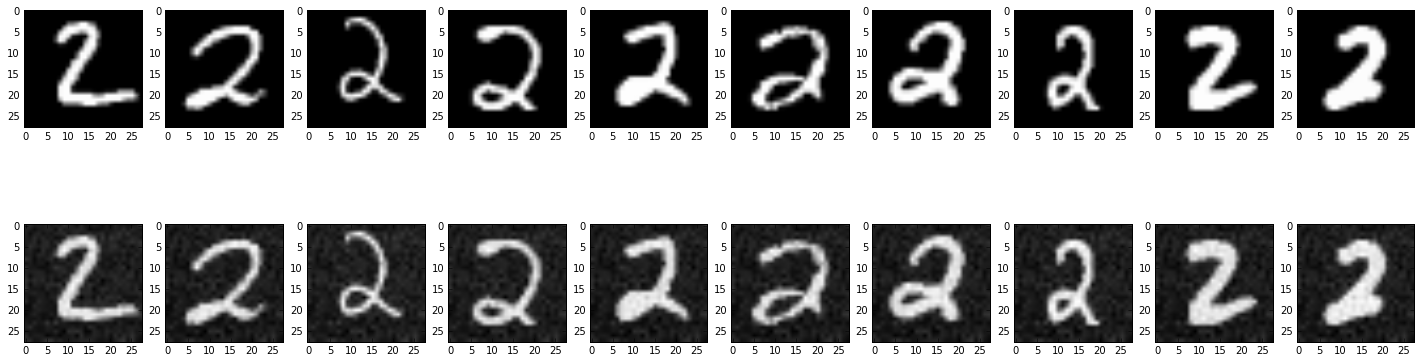

In [6]:
fig, axes = plt.subplots(figsize=(20, 6))
fig.tight_layout()
for i,img in enumerate(twos):
    ax = plt.subplot(2,10,i+1)
    plt.imshow(img.reshape(28,28),cmap='gray')
for i,img in enumerate(twos_manip):
    ax = plt.subplot(2,10,i+11)
    plt.imshow(img.reshape(28,28),cmap='gray')

The difference between each pair of examples are the same in this simple case

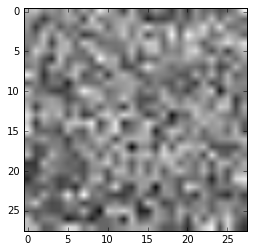

In [7]:
plt.imshow(w[:,6].reshape(28,28),cmap='gray')

### Now use backpropagation to generate new images

The network is changed in fool_network() as follows:

1. Replace the inputs by variables initialized using the images.
2. Replace the outputs by one-hot representation of 6.
3. Set the variable list to the image variables only.
4. Run the optimizer with a slightly higher learning rate, stop when accuracy reaches 1.0 (all images for 2 being categorized as 6).

Now run fool() to generate the images.

In [8]:
new_twos = model.fool(twos)

step 0, cross entropy 13.7838, training accuracy 0
[ 10.31150723  -9.79982185  -6.64802837   8.38155556   8.16083908
   1.52878618  -2.93035412  -0.72770095   6.4878068  -14.58172226]
step 1, cross entropy 12.9036, training accuracy 0
step 2, cross entropy 12.0359, training accuracy 0
step 3, cross entropy 11.1841, training accuracy 0
step 4, cross entropy 10.3533, training accuracy 0
step 5, cross entropy 9.5505, training accuracy 0
step 6, cross entropy 8.782, training accuracy 0.2
step 7, cross entropy 8.04896, training accuracy 0.2
step 8, cross entropy 7.34779, training accuracy 0.2
step 9, cross entropy 6.67502, training accuracy 0.2
step 10, cross entropy 6.03232, training accuracy 0.2
[  7.38996458 -10.2209444   -7.00524521   7.41991138   7.69495678
   1.61274338   2.7627697   -0.8297708    6.19676161 -14.19385242]
step 11, cross entropy 5.42736, training accuracy 0.3
step 12, cross entropy 4.86789, training accuracy 0.4
step 13, cross entropy 4.35698, training accuracy 0.4
ste

Each column shows the original 2's correctly categorized, the weight change during the training, and the adversarial image categorized as 6. Notice the difference needed to fool the network is hardly visible to a naked eye (if you look at the images directly).

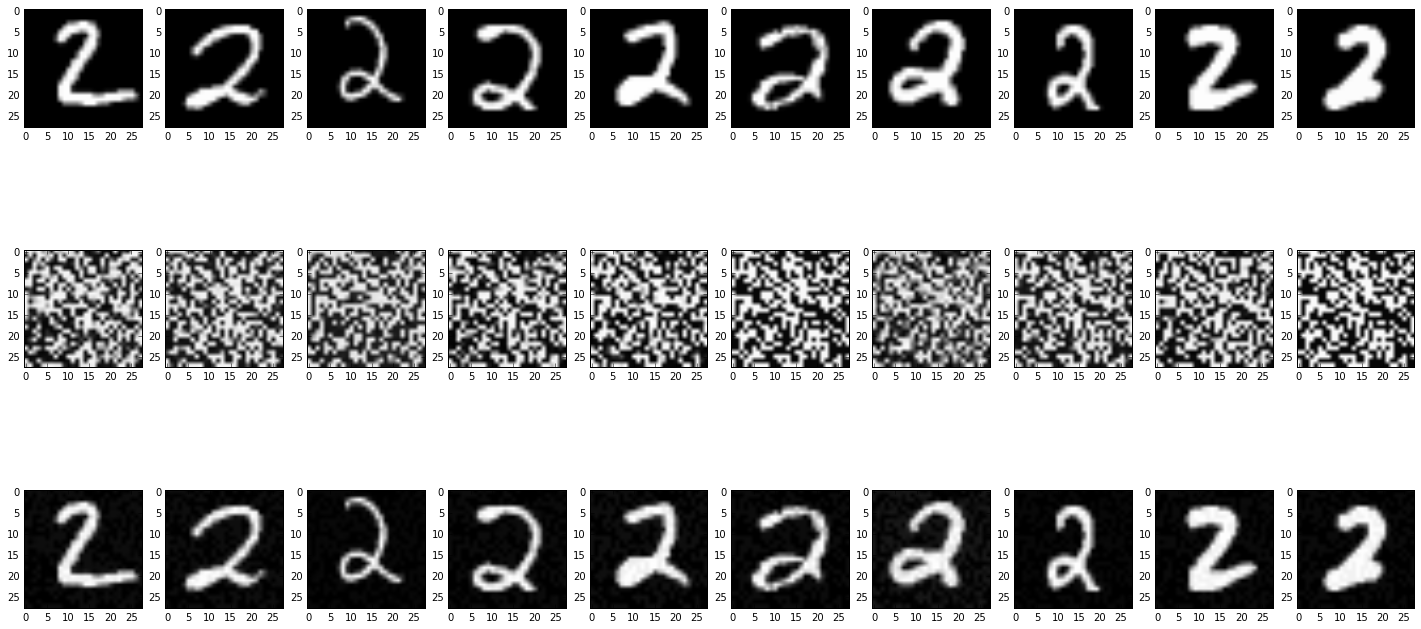

In [9]:
fig, axes = plt.subplots(figsize=(20, 10))
fig.tight_layout()
for i,img in enumerate(twos):
    ax = plt.subplot(3,10,i+1)
    plt.imshow(img.reshape(28,28),cmap='gray')
for i,img in enumerate(new_twos):
    ax = plt.subplot(3,10,i+11)
    plt.imshow((img-twos[i]).reshape(28,28),cmap='gray')
for i,img in enumerate(new_twos):
    ax = plt.subplot(3,10,i+21)
    plt.imshow(img.reshape(28,28),cmap='gray')

### Same method, but on CNN

This backpropagation method can be used on any network. The following example is on a simple convolutional network. 

Defining some necessary layers for CNN.

In [10]:
def conv_relu(input, kernel_shape, bias_shape, scope=None):
    with tf.variable_scope(scope or 'conv_relu'):
        w = tf.get_variable("w", kernel_shape, initializer=tf.random_normal_initializer())
        b = tf.get_variable("b", bias_shape, initializer=tf.constant_initializer(0.0))
        conv = tf.nn.conv2d(input, w, strides=[1, 1, 1, 1], padding='SAME')
        return tf.nn.relu(conv + b)

def max_pool_2x2(x, scope=None):
    with tf.variable_scope(scope or 'max_pool_2x2'):
        return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    
def drop_out(input, keep_prob, scope=None):
    with tf.variable_scope(scope or 'drop_out'):
        return tf.nn.dropout(input, keep_prob)

The network is exactly the same as the example [“Deep MNIST for Experts”](https://www.google.com/url?q=https://www.tensorflow.org/versions/r0.11/tutorials/mnist/pros/index.html%23deep-mnist-for-experts&sa=D&ust=1489723853593000&usg=AFQjCNEw5szSN4k_LTS8TPLjjnf5ugErKQ), only worded differently: Two convolutional layers plus two fully connected layers.

In [11]:
class CNN(object):
    def __init__(self, num_steps, batch_size, log_every):
        self.num_steps = num_steps
        self.batch_size = batch_size
        self.log_every = log_every
        self.hidden_size = 100
        
        with tf.variable_scope('CNN'):
            self._create_model()
        
    def _create_model(self):
        with tf.variable_scope('InOut'):
            self.x = tf.placeholder(tf.float32, shape=(None, 784))
            self.t = tf.placeholder(tf.float32, shape=(None, 10))
        with tf.variable_scope('Hidden'):
            self.conv1 = conv_relu(tf.reshape(self.x,[-1,28,28,1]), [5,5,1,32], 32,'conv1')
            self.pool1 = max_pool_2x2(self.conv1,'pool1')
            self.conv2 = conv_relu(self.pool1, [5,5,32,64], 64,'conv2')
            self.pool2 = max_pool_2x2(self.conv2,'pool2')
            self.fc1 = linear(tf.reshape(self.pool2, [-1, 7*7*64]),1024,'fc1')
            self.keep_prob = tf.placeholder(tf.float32)
            self.drop = drop_out(self.fc1,self.keep_prob,'drop')
            self.y = linear(self.drop,10,'fc2')
        with tf.variable_scope('Opt'):
            self.cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=self.y, labels=self.t))
            self.optimizer = tf.train.AdamOptimizer(1e-4).minimize(self.cross_entropy)
            correct_prediction = tf.equal(tf.argmax(self.y,1), tf.argmax(self.t,1))
            self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    def fool_model(self,imgs,target):
        with tf.variable_scope('Image'):
            img = tf.constant(imgs)
            t = np.zeros([10,10],dtype='float32')
            t[:,target] = 1
            t = tf.constant(t)
           
            self.two = tf.get_variable('imgs', initializer=img)
            self.six = tf.get_variable('targets', initializer=t)
        with tf.variable_scope('Hidden',reuse=True):
            self.conv1 = conv_relu(tf.reshape(self.two,[-1,28,28,1]), [5,5,1,32], 32,'conv1')
            self.pool1 = max_pool_2x2(self.conv1,'pool1')
            self.conv2 = conv_relu(self.pool1, [5,5,32,64], 64,'conv2')
            self.pool2 = max_pool_2x2(self.conv2,'pool2')
            self.fc1 = linear(tf.reshape(self.pool2, [-1, 7*7*64]),1024,'fc1')
            self.keep_prob = tf.placeholder(tf.float32)
            self.drop = drop_out(self.fc1,self.keep_prob,'drop')
            self.y = linear(self.drop,10,'fc2')
        with tf.variable_scope('Opt'):
            self.vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,scope='CNN/Image')
            self.cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=self.y, labels=self.six))
            self.optimizer = tf.train.AdamOptimizer(1e-3).minimize(self.cross_entropy, var_list=self.vars)
            correct_prediction = tf.equal(tf.argmax(self.y,1), tf.argmax(self.six,1))
            self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    def train(self):
        with tf.Session() as session:
            tf.global_variables_initializer().run()
            
            for i in range(self.num_steps):
                batch = mnist.train.next_batch(self.batch_size)
                if i%100 == 0:
                    train_accuracy = session.run(self.accuracy, \
                                                 feed_dict={self.x:batch[0], self.t: batch[1],self.keep_prob:1.0})
                    print("step %d, training accuracy %g"%(i, train_accuracy))
                session.run([self.cross_entropy,self.optimizer], \
                            feed_dict={self.x: batch[0], self.t: batch[1],self.keep_prob:0.5})
            saver = tf.train.Saver()
            save_path = saver.save(session, "./data/CNN.weights")
            print("Model saved in file: %s" % save_path)
            print("test accuracy %g"%session.run(self.accuracy, \
                                                 feed_dict={self.x:mnist.test.images, self.t: mnist.test.labels,self.keep_prob:1.0}))
            
    def fool(self,images,target=6):
        with tf.Session() as session:
            saver = tf.train.Saver()
            save_path = saver.restore(session, "./data/CNN.weights")
            with tf.variable_scope('CNN'):
                self.fool_model(twos,target)
            
            tf.global_variables_initializer().run()
            
            for i in range(300):
                CE,ACC,Y,_ = session.run([self.cross_entropy,self.accuracy,self.y,self.optimizer],feed_dict={self.keep_prob:1.0})
                print("step %d, cross entropy %g, training accuracy %g"%(i, CE, ACC))
                if i%10 == 0:
                    print(Y[0])
                if ACC==1.0:
                    print(Y[0])
                    break
            
            return session.run(self.two)

Build and train the CNN

In [12]:
model = CNN(3000,100,100)

In [13]:
model.train()

step 0, training accuracy 0.12
step 100, training accuracy 0.34
step 200, training accuracy 0.59
step 300, training accuracy 0.64
step 400, training accuracy 0.75
step 500, training accuracy 0.77
step 600, training accuracy 0.85
step 700, training accuracy 0.75
step 800, training accuracy 0.81
step 900, training accuracy 0.88
step 1000, training accuracy 0.84
step 1100, training accuracy 0.91
step 1200, training accuracy 0.92
step 1300, training accuracy 0.93
step 1400, training accuracy 0.84
step 1500, training accuracy 0.91
step 1600, training accuracy 0.94
step 1700, training accuracy 0.92
step 1800, training accuracy 0.92
step 1900, training accuracy 0.94
step 2000, training accuracy 0.87
step 2100, training accuracy 0.88
step 2200, training accuracy 0.89
step 2300, training accuracy 0.97
step 2400, training accuracy 0.93
step 2500, training accuracy 0.92
step 2600, training accuracy 0.93
step 2700, training accuracy 0.91
step 2800, training accuracy 0.88
step 2900, training accura

Now fool it with adversarial images

In [14]:
new_twos = model.fool(twos)

step 0, cross entropy 162321, training accuracy 0
[ 91187.5625     -64471.890625   -50623.59765625  95701.203125   -25640.375
 -30987.078125    27250.625      -73002.0546875   11340.28710938
  67844.84375   ]
step 1, cross entropy 158994, training accuracy 0
step 2, cross entropy 155007, training accuracy 0
step 3, cross entropy 150968, training accuracy 0
step 4, cross entropy 146934, training accuracy 0
step 5, cross entropy 143136, training accuracy 0
step 6, cross entropy 139402, training accuracy 0
step 7, cross entropy 135613, training accuracy 0
step 8, cross entropy 131817, training accuracy 0
step 9, cross entropy 128073, training accuracy 0
step 10, cross entropy 124570, training accuracy 0
[ 84734.671875   -65688.6953125  -50653.01953125  83868.96875    -24017.703125
 -32405.1796875   44666.9296875  -73971.          11022.25585938
  64694.27734375]
step 11, cross entropy 121146, training accuracy 0
step 12, cross entropy 117732, training accuracy 0
step 13, cross entropy 114

Very similar result as the simple linear classifier. But notice the change on the adversarial images are visible.

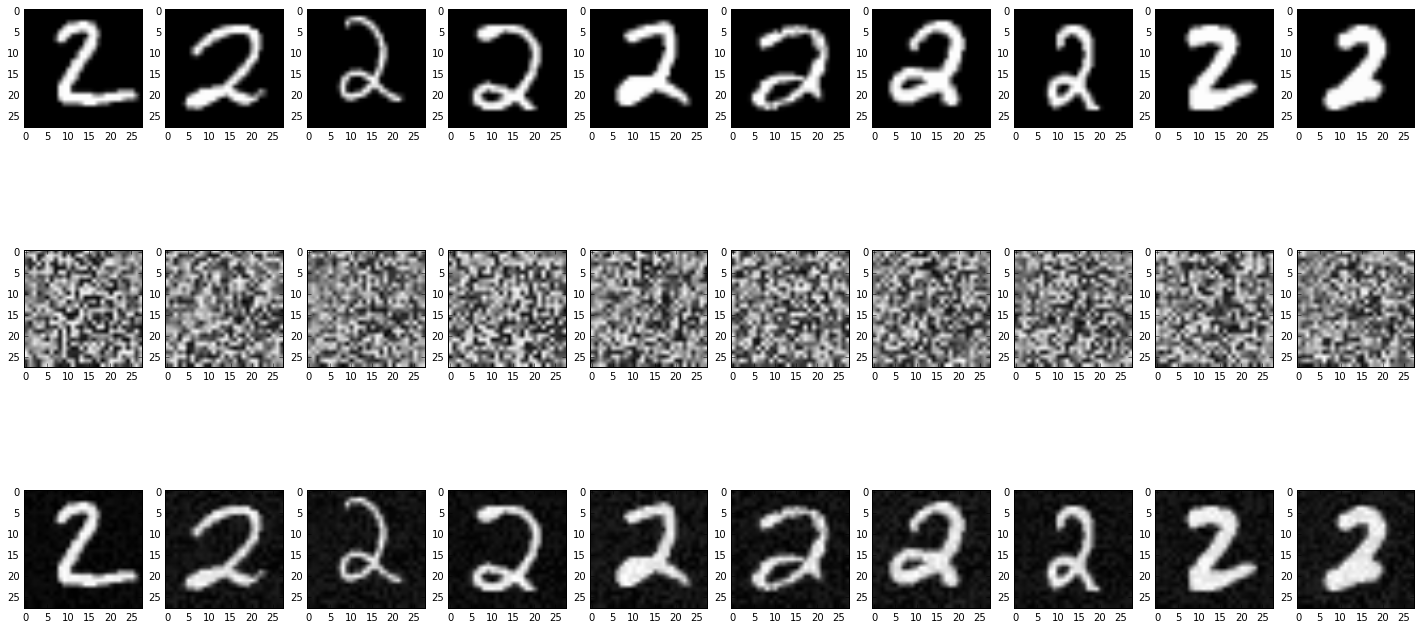

In [15]:
fig, axes = plt.subplots(figsize=(20, 10))
fig.tight_layout()
for i,img in enumerate(twos):
    ax = plt.subplot(3,10,i+1)
    plt.imshow(img.reshape(28,28),cmap='gray')
for i,img in enumerate(new_twos):
    ax = plt.subplot(3,10,i+11)
    plt.imshow((img-twos[i]).reshape(28,28),cmap='gray')
for i,img in enumerate(new_twos):
    ax = plt.subplot(3,10,i+21)
    plt.imshow(img.reshape(28,28),cmap='gray')